# Practical session n°5:

##Part I: Quantile Regression with Neural networks.

* Adapted Cost Function
* Two examples with FCN
* A simultaneous quantile regression

##Part II: Sampling with GANs.

* Basic Principle and First Training
* Limitations
* A Wasserstein GAN

Duration: 4 hours

### Partie I: quantile regression   

In this part, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [18]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 283 (delta 108), reused 139 (delta 86), pack-reused 117
Receiving objects: 100% (283/283), 15.01 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (121/121), done.


**Exercise 1**: an adapted cost function

As seen in the previous practical session n°3, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

In [19]:
os.chdir('ml-student/TP5/')
from utils_TP5 import *

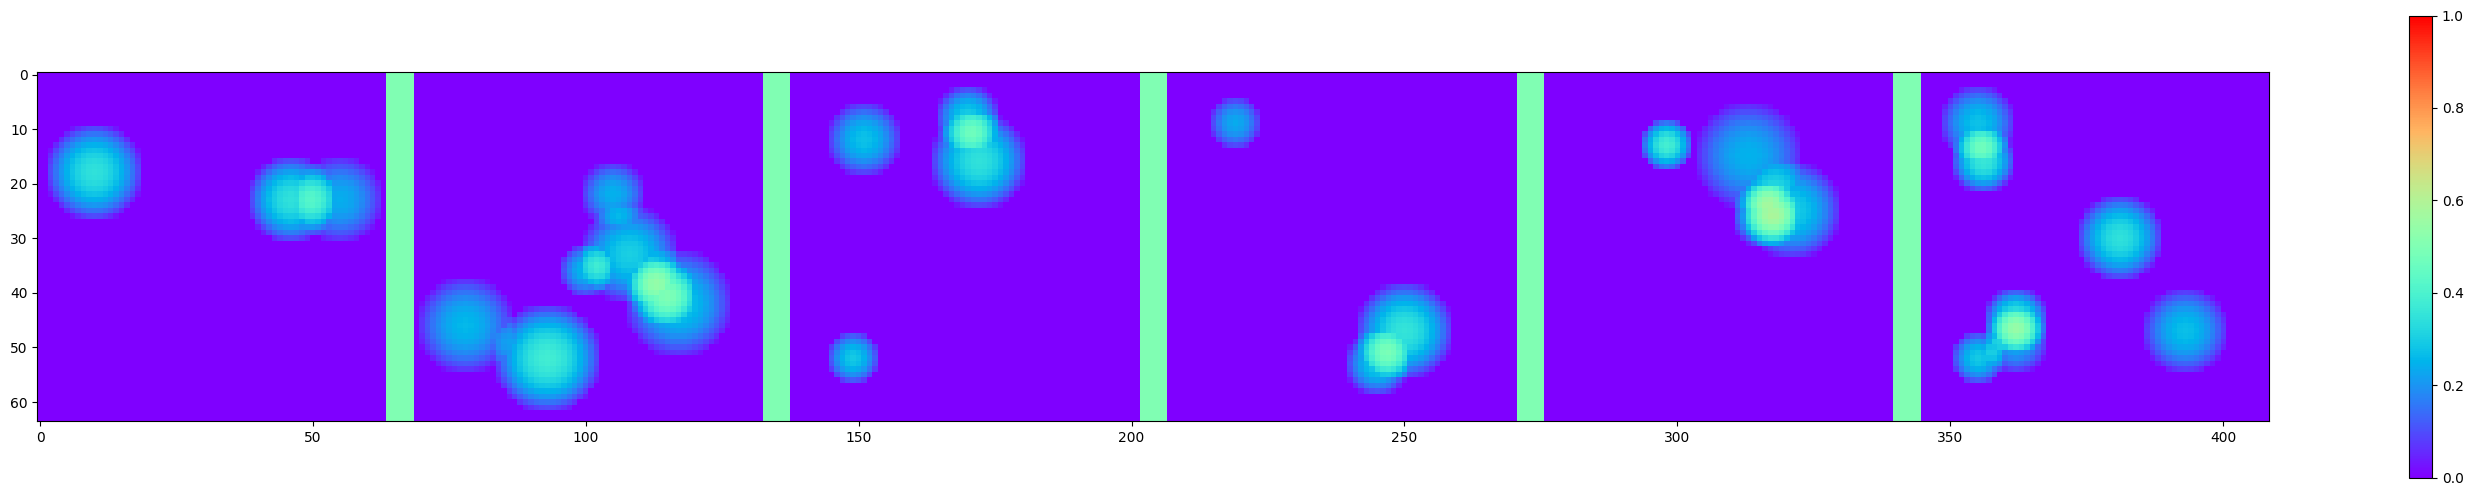

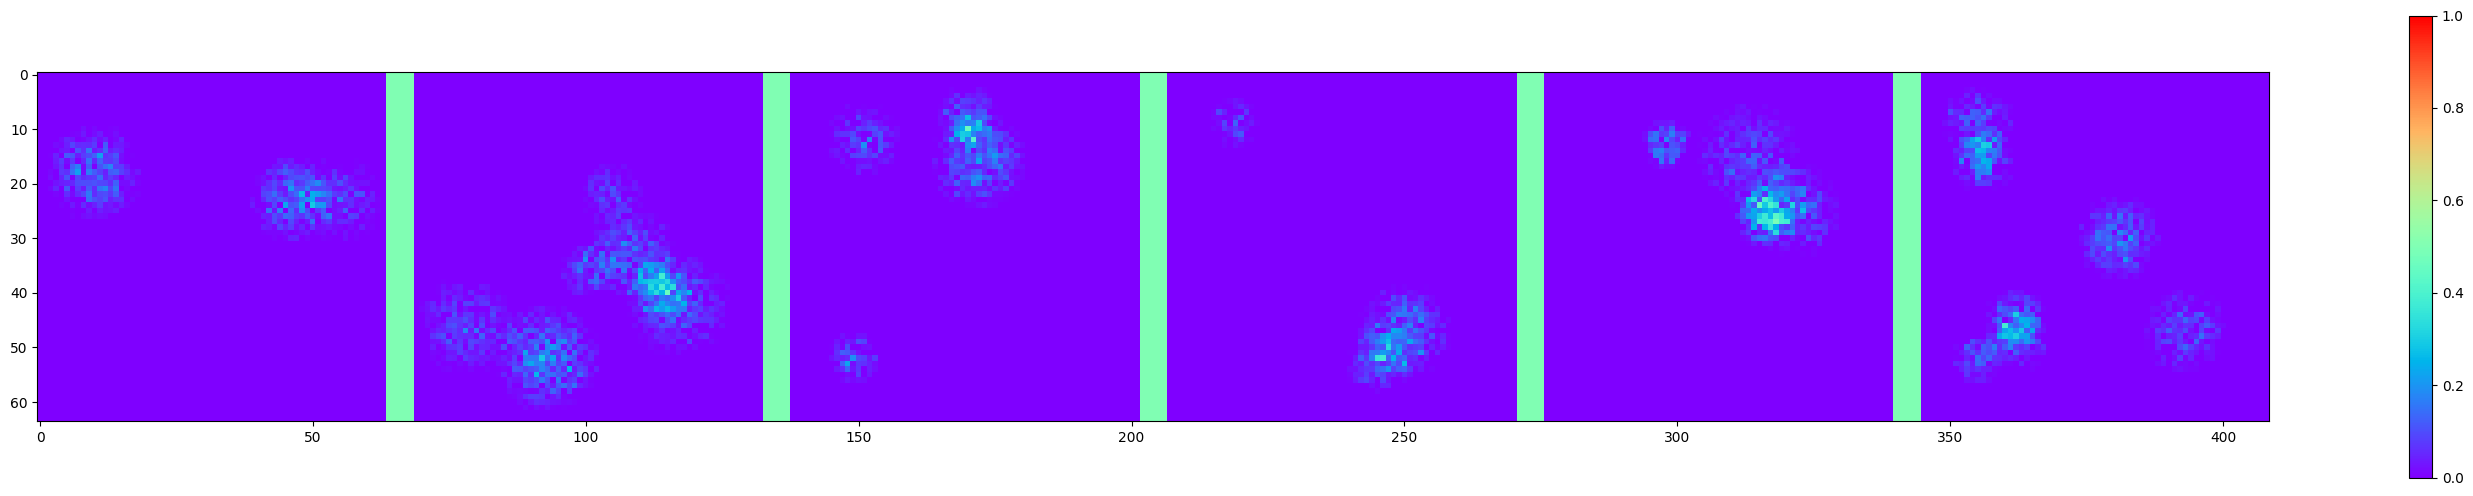

In [20]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y)$$
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

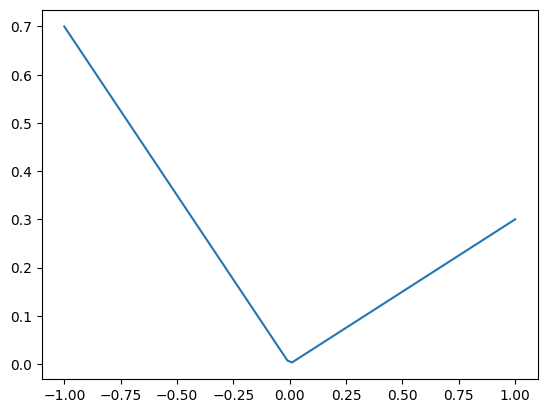

In [47]:
def rho(u,t):
  rho = t*u*(u>=0) + (t-1)*u*(u<=0)
  return rho

U = np.linspace(-1,1,100)
rho_T = []
t =0.3
for u in U :
  rho_T.append(rho(u,t))

plt.plot(U,rho_T)


One can show (see accompanying exercise sheet for the practical session) that the value of $z$ that minimizes the expectation $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , z) ]$ is the $t$-th quantile of the distribution of $y_{i,j}$.

In the context where the value $y_{i,j}$  depends on the image $x$, minimizing $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , f^\theta_{i,j}(x))]$ will therefore constrain the network $f^\theta$ to provide the $t$-th quantile of $p(y_{i,j} | x)$.

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles.

In [56]:
t = 0.1

def rho(u,t):
    #clamp(min=0) prendre la partie positive,  clamp(max=0) prendre la partie -,
    loss = t*u.clamp(min =0) + (t-1)*u.clamp(max = 0)
    loss = loss.mean()
    return loss

def criterion(output, target):
  return rho(target-output, t)


**Q3** Train a U-Net to estimate the ninth decile.

In [61]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [62]:
import torch.optim as optim

fcn = UNet(1,1,8).cuda()

optimizer = optim.Adam(fcn.parameters(),1e-3)
# Training loop
nepochs = 40  # brew a tea while waiting
nbatches = 100  # Number of batches per epoch
batchsize = 32  # Batch size

train_losses = []  # List to store training losses

fcn = fcn.to(device)

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        inputs, targets = gen(batchsize)
        ### BEGIN SOLUTION
        # Move data to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = fcn(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        epoch_losses.append(loss.detach().cpu().item())  # Append the loss
        ### END SOLUTION
    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 1/40
Epoch loss: 0.0470
Epoch 2/40
Epoch loss: 0.0077
Epoch 3/40
Epoch loss: 0.0060
Epoch 4/40
Epoch loss: 0.0049
Epoch 5/40
Epoch loss: 0.0045
Epoch 6/40
Epoch loss: 0.0042
Epoch 7/40
Epoch loss: 0.0042
Epoch 8/40


KeyboardInterrupt: ignored

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

**Exercise 2**: a trickier dependence

Let's now work with the *gen_proba_2* function. Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

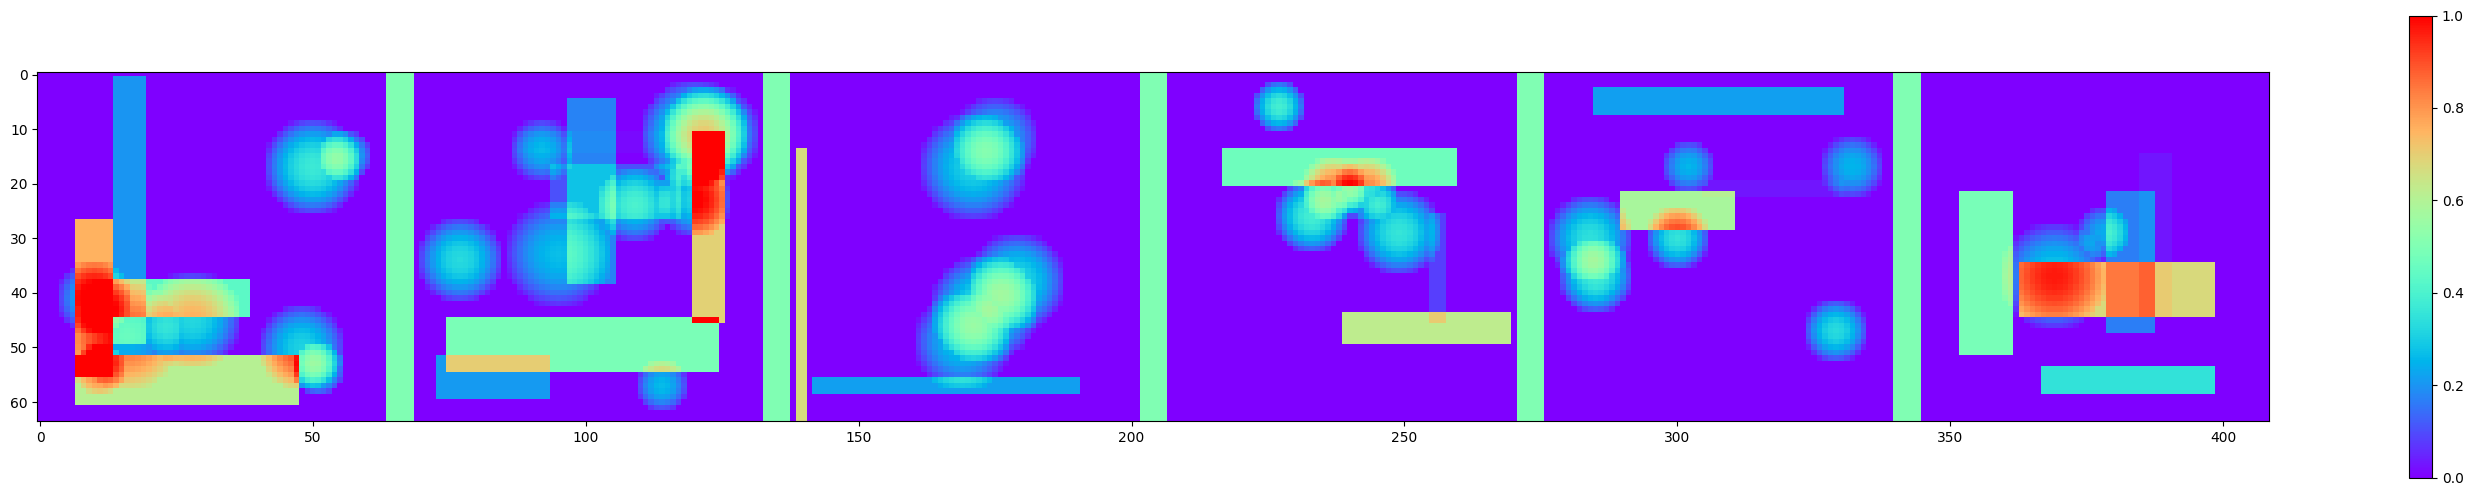

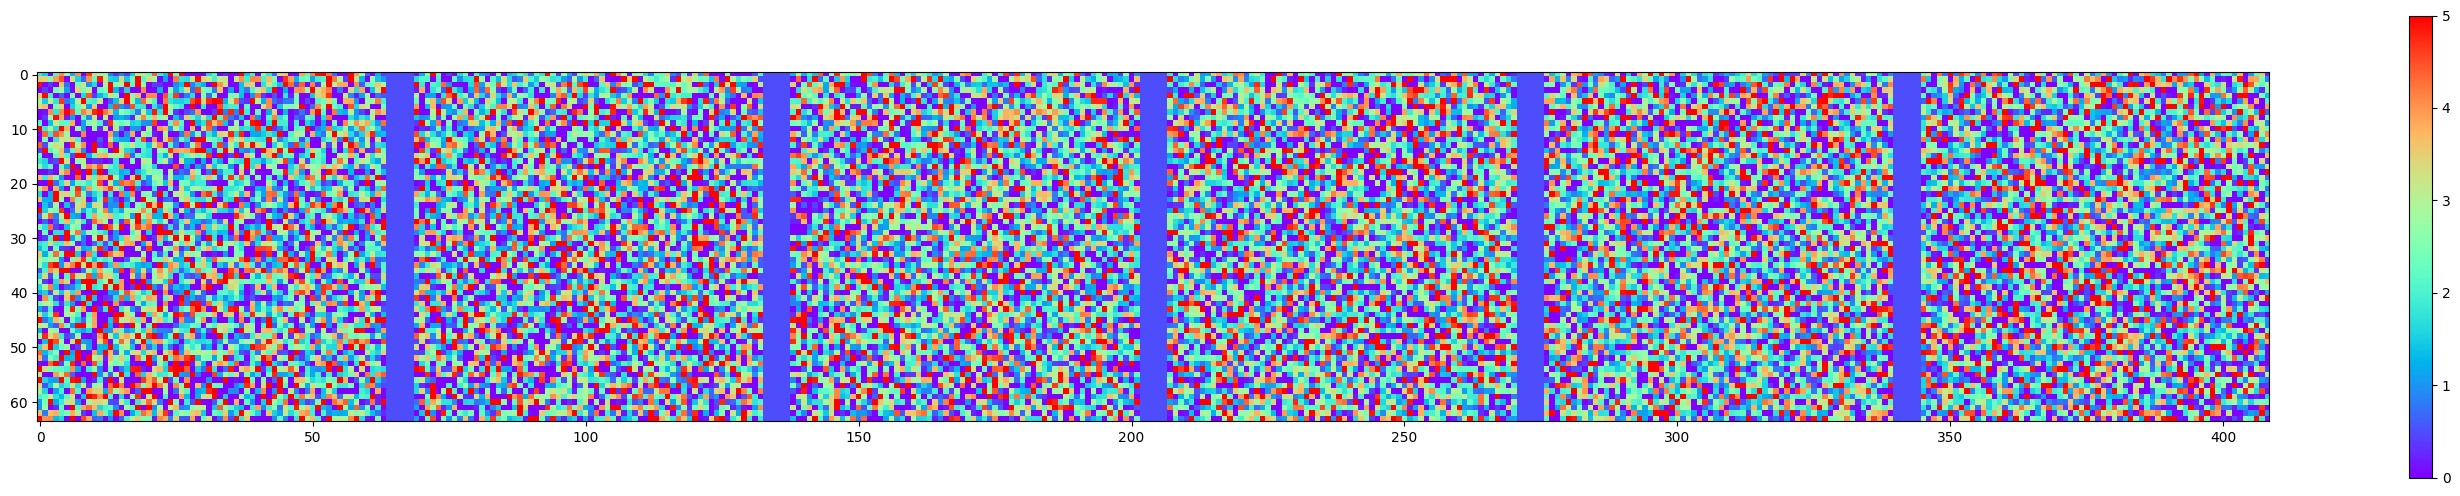

In [ ]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

**Q2** Do we have a dependance ? Is it still a pixel-wise dependence (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)?

**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = ...

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output
        loss_by_pix = ...
        loss = ...

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.